In [ ]:
import os
import numpy as np # type: ignore
import pandas as pd# type: ignore
from scipy.signal import butter, filtfilt# type: ignore
import pickle
from sklearn.preprocessing import LabelEncoder# type: ignore
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier# type: ignore
from sklearn.tree import DecisionTreeClassifier# type: ignore
from sklearn.svm import SVC# type: ignore
from sklearn.linear_model import LogisticRegression# type: ignore
from sklearn.naive_bayes import GaussianNB# type: ignore
from sklearn.neighbors import KNeighborsClassifier# type: ignore
from sklearn.metrics import accuracy_score, classification_report# type: ignore
from statsmodels.tsa.ar_model import AutoReg# type: ignore
import xgboost as xgb# type: ignore
import lightgbm as lgb# type: ignore
from catboost import CatBoostClassifier# type: ignore
from sklearn.model_selection import GridSearchCV# type: ignore
from sklearn.multiclass import OneVsRestClassifier# type: ignore
from collections import Counter
import warnings
import matplotlib.pyplot as plt# type: ignore
import pywt# type: ignore
import csv


#Preprocessing

In [11]:
def Preprocessing(signal, order=2):
    # Band pass filter
    nyq = 0.5 * 176
    low = 0.5 / nyq
    high = 20 / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    band_filtered_data = filtfilt(b, a, signal)
    # NO Resampling (Data is to small)
    # Normalization  between 0 and 1
    normalized_signal = (band_filtered_data - np.min(band_filtered_data)) / (
            np.max(band_filtered_data) - np.min(band_filtered_data))
    #DC component removal
    dc_removed_signal = normalized_signal - np.mean(normalized_signal)
    return dc_removed_signal


#Feature Extraction  Statistical features  Raw samples

In [2]:
def Feature_Extraction_statisticl_features(processed_signal):
    #Mean
    mean_value = np.mean(processed_signal)
    #variance
    variance_value = np.var(processed_signal)
    #STD
    std_deviation = np.std(processed_signal)
    #Energy
    energy_value = np.sum(np.square(processed_signal))
    return [mean_value, variance_value, std_deviation, energy_value]

#output Feature Extraction  Statistical features  Raw samples

In [8]:
warnings.filterwarnings("ignore")
base_directory_path = 'C:\\Users\\Lenovo\\OneDrive\\Desktop\\HCI\\Data'
model_directory = 'saved_models'
categories = ['Up', 'Down', 'Left', 'Right', 'Blink']
label_encoder = LabelEncoder()
label_encoder.fit(['Up', 'Down', 'Left', 'Right', 'Blink'])
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [9]:
def read_and_extract_features(base_path, sub_folder):
    data = []
    labels = []
    for category in categories:
        category_folder = os.path.join(base_path, category, sub_folder)
        files = [f for f in os.listdir(category_folder) if f.endswith('.txt')]
        for file in files:
            file_path = os.path.join(category_folder, file)
            #Save CSV
            """
            if sub_folder == 'Train' :
                if file.endswith('v.txt'):
                    signal = np.loadtxt(file_path)
                    csv_file = 'Train-vertical'
                    with open(csv_file, 'w', newline=''):
                        csv.DictWriter(signal,fieldnames=file)
                else:
                    signal = np.loadtxt(file_path)
                    csv_file = 'Train-Horizontal'
                    with open(csv_file, 'w', newline=''):
                        csv.DictWriter(signal,fieldnames=file)
            else:
                if file.endswith('h.txt'):
                    signal = np.loadtxt(file_path)
                    csv_file = 'Test-vertical'
                    with open(csv_file, 'w', newline=''):
                        csv.DictWriter(signal,fieldnames=file)
                else:
                    signal = np.loadtxt(file_path)
                    csv_file = 'Test-Horizontal'
                    with open(csv_file, 'w', newline=''):
                        csv.DictWriter(signal,fieldnames=file)        
              """
            try:
                signal = np.loadtxt(file_path)
                processed_signal = Preprocessing(signal, 1)
                features = Feature_Extraction_statisticl_features(processed_signal)
                data.append(features)
                labels.append(category)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
    #Concatenating features HEOG & VEOG
    for i in range(len(data), 2):
         #HEOG & VEOG
         if data[i + 1]!=None:
            data[i/2] = pd.concat([data[i], data[i + 1]], axis=1)
         else:
            data[i / 2]=data[i]

    return np.array(data), labels

Random Forest Results:
Best Parameters: {'max_depth': 10, 'n_estimators': 100}
Accuracy Train : 1.0
Accuracy Test : 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00        13

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46

SVM RBF (OvA) Results:
Best Parameters: {'estimator__C': 1000, 'estimator__gamma': 1}
Accuracy Train : 0.7757847533632287
Accuracy Test : 0.7391304347826086
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         9
           1       0.67      0.75      0.71         8
           2       0.80  

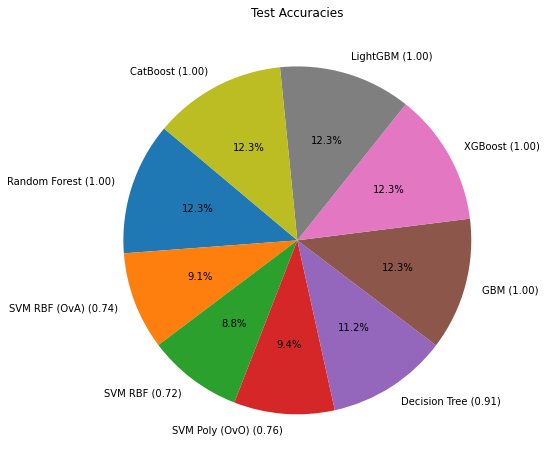

In [12]:
#Train Data With Grid Search
def train_classifier_with_gridsearch(clf, param_grid, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5)
    grid_search.fit(X_train, y_train)
    best_clf = grid_search.best_estimator_
    y_pred_test = best_clf.predict(X_test)
    y_pred_train = best_clf.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    classification_rep = classification_report(y_test, y_pred_test)
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Accuracy Train : {accuracy_train}")
    print(f"Accuracy Test : {accuracy_test}")
    print("Classification Report:")
    print(classification_rep)
    #model_filename = os.path.join(model_directory, type(clf).__name__ + '_model.pkl')
    #with open(model_filename, 'wb') as f:
    #pickle.dump(best_clf, f)
    #print(f"Saved model to {model_filename}")
    return accuracy_test, classification_rep


X_train, y_train = read_and_extract_features(base_directory_path, 'Train')
X_test, y_test = read_and_extract_features(base_directory_path, 'Test')
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
classifiers = {
    'Random Forest': (
        RandomForestClassifier(random_state=42), {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]}),
    'SVM RBF (OvA)': (OneVsRestClassifier(SVC(kernel='rbf', random_state=42)),
                      {'estimator__C': [1, 10, 100, 1000], 'estimator__gamma': [0.001, 0.01, 0.1, 1]}),
    'SVM RBF': (SVC(kernel='rbf', random_state=42), {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1]}),
    'SVM Poly (OvO)': (SVC(kernel='poly', decision_function_shape='ovo', random_state=42),
                       {'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4], 'coef0': [0, 1, 10]}),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {'max_depth': [3, 5, 7, 10]}),
    'GBM': (GradientBoostingClassifier(random_state=42),
            {'n_estimators': [50, 100, 500, 1000], 'learning_rate': [0.01, 0.1, 0.2]}),
    'XGBoost': (xgb.XGBClassifier(eval_metric='mlogloss', random_state=42),
                {'n_estimators': [50, 100, 500], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}),
    'LightGBM': (lgb.LGBMClassifier(random_state=42),
                 {'n_estimators': [50, 100, 500], 'learning_rate': [0.01, 0.1, 0.2], 'num_leaves': [31, 62]}),
}
test_accuracies = {}
classification_reports = {}

for name, (classifier, param_grid) in classifiers.items():
    print(f"{name} Results:")
    test_accuracy, class_report = train_classifier_with_gridsearch(classifier, param_grid, X_train, y_train, X_test,
                                                                   y_test)
    test_accuracies[name] = test_accuracy
    classification_reports[name] = class_report

cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)
y_pred_Test = cat_model.predict(X_test)
accuracy_Test = accuracy_score(y_test, y_pred_Test)
classification_rep_cat = classification_report(y_test, y_pred_Test)
print("CatBoost Accuracy Test : ", f"{accuracy_Test}")
print("CatBoost Classification Report:")
print(classification_rep_cat)
#model_filename = os.path.join(model_directory, "CatBoost_model.pkl")
#with open(model_filename, 'wb') as file:
#pickle.dump(cat_model, file)
#print(f"Model saved to {model_filename}")
test_accuracies["CatBoost"] = accuracy_Test
classification_reports["CatBoost"] = classification_rep_cat
labels = [f"{name} ({test_acc:.2f})" for name, test_acc in test_accuracies.items()]
plt.figure(figsize=(8, 8))
plt.pie(test_accuracies.values(), labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Test Accuracies')
plt.show()

#Feature Extraction  Statistical features & DWT

In [13]:
def Feature_Extraction_with_DWT(signal, wavelet='db4', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    features = []
    for coeff in coeffs:
        # Mean ,Variance,STD,Energy
        features.extend([np.mean(coeff), np.std(coeff), np.var(coeff), np.sum(np.square(coeff))])
    return features

In [14]:
def read_and_extract_features(base_path, sub_folder):
    data = []
    labels = []
    for category in categories:
        category_folder = os.path.join(base_path, category, sub_folder)
        files = [f for f in os.listdir(category_folder) if f.endswith('.txt')]
        for file in files:
            file_path = os.path.join(category_folder, file)
            try:
                signal = np.loadtxt(file_path)
                processed_signal = Preprocessing(signal, 1)
                features = Feature_Extraction_with_DWT(processed_signal)
                data.append(features)
                labels.append(category)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
        # Concatenating features HEOG & VEOG
        for i in range(len(data), 2):
         #HEOG & VEOG
         if data[i + 1]!=None:
            data[i/2] = pd.concat([data[i], data[i + 1]], axis=1)
         else:
            data[i / 2]=data[i]

    return np.array(data), labels

Random Forest Results:
Best Parameters: {'max_depth': 10, 'n_estimators': 300}
Accuracy Train : 1.0
Accuracy Test : 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00         8
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00        13

    accuracy                           1.00        46
   macro avg       1.00      1.00      1.00        46
weighted avg       1.00      1.00      1.00        46

SVM RBF (OvA) Results:
Best Parameters: {'estimator__C': 1000, 'estimator__gamma': 0.01}
Accuracy Train : 0.6995515695067265
Accuracy Test : 0.7391304347826086
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.88      0.88      0.88         8
           2       0.8

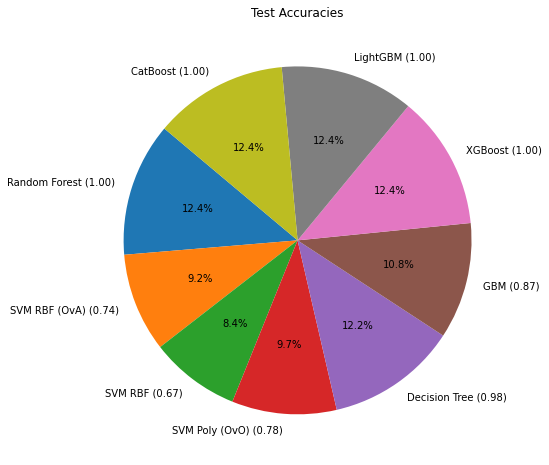

In [15]:
#Train Data With Grid Search
def train_classifier_with_gridsearch(clf, param_grid, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5)
    grid_search.fit(X_train, y_train)
    best_clf = grid_search.best_estimator_
    y_pred_test = best_clf.predict(X_test)
    y_pred_train = best_clf.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    classification_rep = classification_report(y_test, y_pred_test)
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Accuracy Train : {accuracy_train}")
    print(f"Accuracy Test : {accuracy_test}")
    print("Classification Report:")
    print(classification_rep)
    #model_filename = os.path.join(model_directory, type(clf).__name__ + '_model.pkl')
    #with open(model_filename, 'wb') as f:
    #pickle.dump(best_clf, f)
    #print(f"Saved model to {model_filename}")
    return accuracy_test, classification_rep


X_train, y_train = read_and_extract_features(base_directory_path, 'Train')
X_test, y_test = read_and_extract_features(base_directory_path, 'Test')
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
classifiers = {
    'Random Forest': (
        RandomForestClassifier(random_state=42), {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]}),
    'SVM RBF (OvA)': (OneVsRestClassifier(SVC(kernel='rbf', random_state=42)),
                      {'estimator__C': [1, 10, 100, 1000], 'estimator__gamma': [0.001, 0.01, 0.1, 1]}),
    'SVM RBF': (SVC(kernel='rbf', random_state=42), {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1]}),
    'SVM Poly (OvO)': (SVC(kernel='poly', decision_function_shape='ovo', random_state=42),
                       {'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4], 'coef0': [0, 1, 10]}),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {'max_depth': [3, 5, 7, 10]}),
    'GBM': (GradientBoostingClassifier(random_state=42),
            {'n_estimators': [50, 100, 500, 1000], 'learning_rate': [0.01, 0.1, 0.2]}),
    'XGBoost': (xgb.XGBClassifier(eval_metric='mlogloss', random_state=42),
                {'n_estimators': [50, 100, 500], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}),
    'LightGBM': (lgb.LGBMClassifier(random_state=42),
                 {'n_estimators': [50, 100, 500], 'learning_rate': [0.01, 0.1, 0.2], 'num_leaves': [31, 62]}),
}
test_accuracies = {}
classification_reports = {}

for name, (classifier, param_grid) in classifiers.items():
    print(f"{name} Results:")
    test_accuracy, class_report = train_classifier_with_gridsearch(classifier, param_grid, X_train, y_train, X_test,
                                                                   y_test)
    test_accuracies[name] = test_accuracy
    classification_reports[name] = class_report

cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)
y_pred_Test = cat_model.predict(X_test)
accuracy_Test = accuracy_score(y_test, y_pred_Test)
classification_rep_cat = classification_report(y_test, y_pred_Test)
print("CatBoost Accuracy Test : ", f"{accuracy_Test}")
print("CatBoost Classification Report:")
print(classification_rep_cat)
#model_filename = os.path.join(model_directory, "CatBoost_model.pkl")
#with open(model_filename, 'wb') as file:
#pickle.dump(cat_model, file)
#print(f"Model saved to {model_filename}")
test_accuracies["CatBoost"] = accuracy_Test
classification_reports["CatBoost"] = classification_rep_cat
labels = [f"{name} ({test_acc:.2f})" for name, test_acc in test_accuracies.items()]
plt.figure(figsize=(8, 8))
plt.pie(test_accuracies.values(), labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Test Accuracies')
plt.show()

#Feature_Extraction_with_DWTonly

In [18]:
def Feature_Extraction_with_DWTonly(signal, wavelet='db4', level=5):
    coeffs = pywt.wavedec(signal, wavelet, level=level)
    features_array = np.array(coeffs).reshape(1, -1)
    return features_array

In [19]:
def read_and_extract_features(base_path, sub_folder):
    data = []
    labels = []
    for category in categories:
        category_folder = os.path.join(base_path, category, sub_folder)
        files = [f for f in os.listdir(category_folder) if f.endswith('.txt')]
        for file in files:
            file_path = os.path.join(category_folder, file)
            try:
                signal = np.loadtxt(file_path)
                processed_signal = Preprocessing(signal, 1)
                features = Feature_Extraction_with_DWTonly(processed_signal)
                data.append(features)
                labels.append(category)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
        # Concatenating features HEOG & VEOG
        for i in range(len(data), 2):
         #HEOG & VEOG
         if data[i + 1]!=None:
            data[i/2] = pd.concat([data[i], data[i + 1]], axis=1)
         else:
            data[i / 2]=data[i]

    return np.array(data), labels

Random Forest Results:
Best Parameters: {'max_depth': 5, 'n_estimators': 300}
Accuracy Train : 0.800896860986547
Accuracy Test : 0.8304347826086957
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.56      0.71         9
           1       0.80      0.50      0.62         8
           2       0.62      0.62      0.62         8
           3       0.75      0.38      0.50         8
           4       0.50      0.92      0.65        13

    accuracy                           0.63        46
   macro avg       0.73      0.60      0.62        46
weighted avg       0.72      0.63      0.63        46

SVM RBF (OvA) Results:
Best Parameters: {'estimator__C': 1, 'estimator__gamma': 0.1}
Accuracy Train : 0.590134529147982
Accuracy Test : 0.5695652173913044
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.56      0.67         9
           1       0.00      0.00      0.00         8

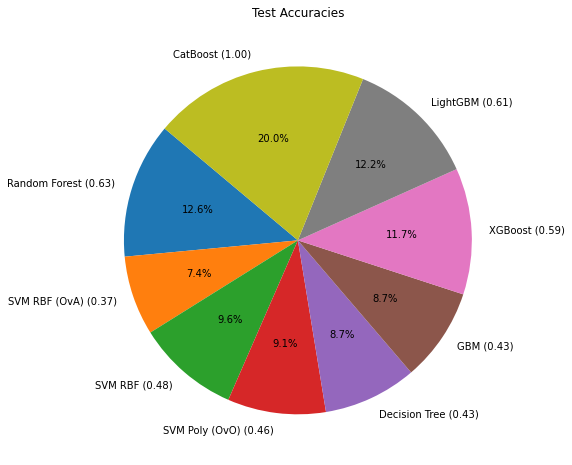

In [20]:
#Train Data With Grid Search
def train_classifier_with_gridsearch(clf, param_grid, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='accuracy', cv=5)
    grid_search.fit(X_train, y_train)
    best_clf = grid_search.best_estimator_
    y_pred_test = best_clf.predict(X_test)
    y_pred_train = best_clf.predict(X_train)
    accuracy_train = accuracy_score(y_train, y_pred_train)
    accuracy_test = accuracy_score(y_test, y_pred_test)
    classification_rep = classification_report(y_test, y_pred_test)
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Accuracy Train : {accuracy_train}")
    print(f"Accuracy Test : {accuracy_test}")
    print("Classification Report:")
    print(classification_rep)
    #model_filename = os.path.join(model_directory, type(clf).__name__ + '_model.pkl')
    #with open(model_filename, 'wb') as f:
    #pickle.dump(best_clf, f)
    #print(f"Saved model to {model_filename}")
    return accuracy_test, classification_rep


X_train, y_train = read_and_extract_features(base_directory_path, 'Train')
X_test, y_test = read_and_extract_features(base_directory_path, 'Test')
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
classifiers = {
    'Random Forest': (
        RandomForestClassifier(random_state=42), {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15]}),
    'SVM RBF (OvA)': (OneVsRestClassifier(SVC(kernel='rbf', random_state=42)),
                      {'estimator__C': [1, 10, 100, 1000], 'estimator__gamma': [0.001, 0.01, 0.1, 1]}),
    'SVM RBF': (SVC(kernel='rbf', random_state=42), {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.01, 0.1, 1]}),
    'SVM Poly (OvO)': (SVC(kernel='poly', decision_function_shape='ovo', random_state=42),
                       {'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4], 'coef0': [0, 1, 10]}),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {'max_depth': [3, 5, 7, 10]}),
    'GBM': (GradientBoostingClassifier(random_state=42),
            {'n_estimators': [50, 100, 500, 1000], 'learning_rate': [0.01, 0.1, 0.2]}),
    'XGBoost': (xgb.XGBClassifier(eval_metric='mlogloss', random_state=42),
                {'n_estimators': [50, 100, 500], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}),
    'LightGBM': (lgb.LGBMClassifier(random_state=42),
                 {'n_estimators': [50, 100, 500], 'learning_rate': [0.01, 0.1, 0.2], 'num_leaves': [31, 62]}),
}
test_accuracies = {}
classification_reports = {}

for name, (classifier, param_grid) in classifiers.items():
    print(f"{name} Results:")
    test_accuracy, class_report = train_classifier_with_gridsearch(classifier, param_grid, X_train, y_train, X_test,
                                                                   y_test)
    test_accuracies[name] = test_accuracy
    classification_reports[name] = class_report

cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)
y_pred_Test = cat_model.predict(X_test)
accuracy_Test = accuracy_score(y_test, y_pred_Test)
classification_rep_cat = classification_report(y_test, y_pred_Test)
print("CatBoost Accuracy Test : ", f"{accuracy_Test}")
print("CatBoost Classification Report:")
print(classification_rep_cat)
#model_filename = os.path.join(model_directory, "CatBoost_model.pkl")
#with open(model_filename, 'wb') as file:
#pickle.dump(cat_model, file)
#print(f"Model saved to {model_filename}")
test_accuracies["CatBoost"] = accuracy_Test
classification_reports["CatBoost"] = classification_rep_cat
labels = [f"{name} ({test_acc:.2f})" for name, test_acc in test_accuracies.items()]
plt.figure(figsize=(8, 8))
plt.pie(test_accuracies.values(), labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Test Accuracies')
plt.show()